In [1]:
import os
import itertools
import importlib
import time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
import datetime as dt
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.patches as mpatches
from pdb import set_trace

from gfatpy.lidar.preprocessing import preprocess
from gfatpy.lidar.preprocessing.lidar_preprocessing import apply_dead_time_correction
from gfatpy.lidar.preprocessing.lidar_preprocessing_tools import preprocessing_photoncounting_signal
from gfatpy.lidar.preprocessing.gluing_proportional import gluing
from gfatpy.lidar.preprocessing.lidar_gluing_damico import gluing as gluing_damico
from gfatpy.utils.utils import residuals
from gfatpy.utils.optimized import windowed_corrcoefs
%matplotlib inline

In [2]:
data = r'C:\Users\asus\Desktop\gfatpy\datos\ALHAMBRA\19\alh_1a_Prs_rs_xf_20230219.nc'
lidar = preprocess(data, apply_dt=False, save_bg=True, save_dc=True)

In [7]:
#Best glue height
glue_range = np.arange(500, 5000, 250)
glue_window = np.arange(500, 2250, 250)
glue_ini = glue_range[0]

for i in range(len(glue_window)):
    vars()['r_raw_'+str(glue_window[i])]=np.ones(len(glue_range))*np.nan #para trabajar cadena de texto
    for idx_glue, glue_ini in enumerate(glue_range):    
        signal_an = lidar.signal_355fpa.sel(time=slice('2023-02-19T09:10:00.0', '2023-02-19T09:15:00.0'), range=slice(glue_ini,glue_ini+glue_window[i])).mean('time')
        signal_pc = lidar.signal_355fpp.sel(time=slice('2023-02-19T09:10:00.0', '2023-02-19T09:15:00.0'), range=slice(glue_ini,glue_ini+glue_window[i])).mean('time')
        #plt.scatter(signal_an, signal_pc)
        #     ranges = signal_an.range

        #Gluing raw
        #Gluing coefficients    
        vars()['r_raw_'+str(glue_window[i])][idx_glue] = np.corrcoef(signal_an, signal_pc)[0,1]

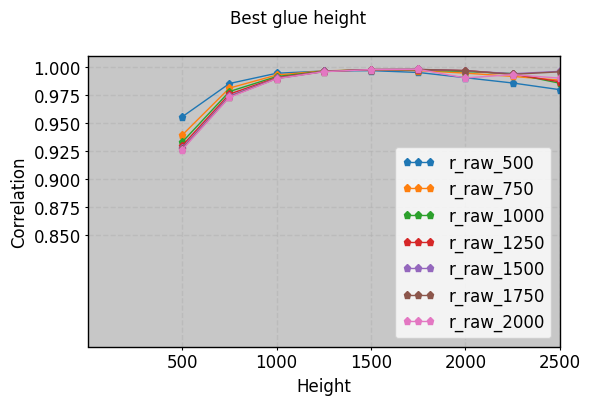

In [9]:
for i in range(len(glue_window)): # para graficar todos juntos
    plt.plot(glue_range, vars()['r_raw_'+str(glue_window[i])], marker='p', label='r_raw_'+ str(glue_window[i]))

plt.legend(loc='best')
plt.xlabel('Height')
plt.ylabel('Correlation')

plt.xticks(np.arange(500, 5500, 500))
plt.yticks(np.arange(0.85, 1.01, 0.025))
plt.grid(linestyle='--')

plt.figtext(0.5, 0.90,"Best glue height", ha='center', fontsize='12') 

plt.xlim(0,2500)

plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.show()

In [11]:
signal_an = lidar.signal_355fpa.sel(time=slice('2023-02-19T09:10:00.0', '2023-02-19T09:15:00.0'), range=slice(1000.,4000.)).mean('time')
signal_pc = lidar.signal_355fpp.sel(time=slice('2023-02-19T09:10:00.0', '2023-02-19T09:15:00.0'), range=slice(1000.,4000.)).mean('time')
#bg_pc = lidar.bg_532xpp.sel(time=slice('2021-07-05T09:10:00.0', '2021-07-05T09:15:00.0')).mean('time')
ranges = signal_an.range
gluing_height = 1500  # parametro que cambia segun grafica anterior
gluing_window = 1000  # rango de altura entre el mejor ajuste de r_raw
#Gluing raw
#Gluing coefficients
fit_values = np.polyfit(signal_an, signal_pc,1)
an2pc = np.polyval(fit_values,signal_an)

signal_gl_raw = np.ones(len(ranges))*np.nan
signal_gl_raw[ranges<gluing_height] = an2pc[ranges<gluing_height] 
signal_gl_raw[ranges>gluing_height] = signal_pc[ranges>gluing_height]

r_raw = np.corrcoef(signal_an, signal_pc)[0]
dict_pc = {}
tau_range = np.arange(4,8,0.25) # rango establecido
residuos = {}
signal_gl = {}
residuo_gl = np.ones(len(tau_range))*np.nan
corrected_r = np.ones(len(tau_range))*np.nan

for idx_tau, tau_ in enumerate(tau_range):
    tau_us = tau_ * 1e-3
    dict_pc[tau_] = signal_pc / (1 - signal_pc * tau_us)
    corrected_r[idx_tau] = np.corrcoef(signal_an, dict_pc[tau_])[0,1]
    
    #Gluing coefficients
    fit_values = np.polyfit(signal_an, dict_pc[tau_],1)
    an2pc = np.polyval(fit_values,signal_an)

    signal_gl_ = np.ones(len(ranges))*np.nan
    signal_gl_[ranges<gluing_height] = an2pc[ranges<gluing_height] 
    signal_gl_[ranges>gluing_height] = dict_pc[tau_][ranges>gluing_height]
    signal_gl[tau_] = signal_gl_
    residuo_gl[idx_tau] = residuals(dict_pc[tau_], signal_gl_)

fit2 = np.polyfit(tau_range, residuo_gl,4)    


{4.5: -0.007871244099320052}


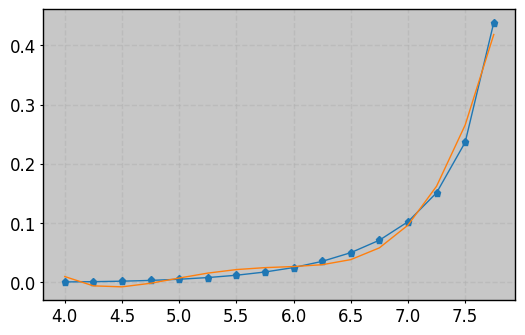

In [12]:
min_values = {}

for i in range(0, len(np.polyval(fit2,tau_range))):
    if np.polyval(fit2,tau_range)[i]== min(np.polyval(fit2,tau_range)):
        min_values[tau_range[i]] = np.min(np.polyval(fit2,tau_range))
        #min_values.append((tau_range[i], np.min(np.polyval(fit2,tau_range))))
        print(min_values)

plt.plot(tau_range, residuo_gl, marker='p')
plt.plot(tau_range, np.polyval(fit2,tau_range)) #ajuste
plt.grid(linestyle='--')
plt.show()

In [7]:
import pickle

In [13]:
#Correct tau
tau = 5.75 # valor de tau que se utilizará para corregir la señal, pero que es residuo realmente
tau_us = tau* 1e-3
corrected_signal_pc = signal_pc / (1 - signal_pc * tau_us)

#Gluing coefficients
fit_an = signal_an.sel(range=slice(gluing_height-gluing_window/2, gluing_height+gluing_window/2))
fit_pc = signal_pc.sel(range=slice(gluing_height-gluing_window/2, gluing_height+gluing_window/2))
fit_corrected_signal_pc = corrected_signal_pc.sel(range=slice(gluing_height-gluing_window/2, gluing_height+gluing_window/2))
#Fit antiguo (PC sin corregir de DT)
fit_values = np.polyfit(fit_an, fit_pc,1)
an2pc = np.polyval(fit_values,signal_an)
signal_gl = np.ones(len(ranges))*np.nan
signal_gl[ranges<1000] = an2pc[ranges<1000]   #señales menores a
signal_gl[ranges>1000] = signal_pc[ranges>1000] #señales mayores a

#Fit nuevo (PC sin corregir de DT)
corrected_fit_values = np.polyfit(fit_an, fit_corrected_signal_pc,1)
an2pc = np.polyval(corrected_fit_values, signal_an)
c_signal_gl = np.ones(len(ranges))*np.nan
c_signal_gl[ranges<1000] = an2pc[ranges<1000]   #señales menores a
c_signal_gl[ranges>1000] = corrected_signal_pc[ranges>1000] #señales mayores a

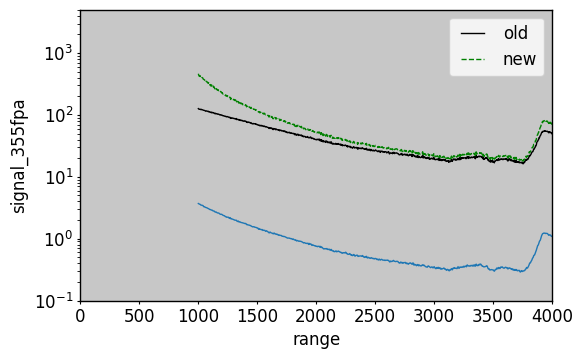

In [14]:
signal_an.plot()
plt.plot(ranges, signal_gl, c='k', label='old')
plt.plot(ranges, c_signal_gl, c='g', ls='--',label='new')
plt.ylim(0.1,5000)
plt.xlim(0,4000)
plt.yscale('log')
plt.legend()